# AAPL Time Series Statistical Analysis
**Project 2 | Quantitative Finance | 2019–2024**

> *"In God we trust. All others must bring data."* — W. Edwards Deming

---

## Objectives
1. Characterise the statistical properties of AAPL equity returns
2. Test for stationarity (ADF + KPSS)
3. Identify autocorrelation structure (ACF / PACF)
4. Decompose price into trend, seasonality, and residual
5. Quantify risk via VaR, CVaR, and drawdown analysis

## Stack
- `numpy`, `scipy`, `pandas` — computation
- `matplotlib`, `seaborn` — visualisation
- All statistical tests implemented **from first principles** (no statsmodels dependency)


In [1]:
# ── Environment setup ──────────────────────────────────────────────────────
import sys, warnings
sys.path.insert(0, '..')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'

print('Environment ready ✓')
print(f'NumPy {np.__version__} | pandas {pd.__version__}')

Environment ready ✓
NumPy 1.26.4 | pandas 2.2.3


## 1. Data Loading & Validation

In [2]:
from src.data_loader import load_data

df = load_data()
close = df['Close']

print(f'Shape: {df.shape}')
print(f'Period: {df.index.min().date()} → {df.index.max().date()}')
print(f'Trading days: {len(df):,}')
df.head()

Shape: (1305, 5)
Period: 2019-01-01 → 2024-01-01
Trading days: 1,305


,Open,High,Low,Close,Volume
Date,,,,,
2019-01-01,151.5102,152.3372,150.4698,151.8047,83735381
2019-01-02,153.6251,153.6061,152.7381,153.4085,102549500
2019-01-03,154.7339,156.8060,154.0613,155.2126,128907556
2019-01-04,153.0770,154.5324,152.8702,152.8891,121512258
2019-01-07,159.7318,161.8075,158.4292,159.9990,80024762


In [3]:
# Data quality check
print('Null values:\n', df.isnull().sum())
print('\nData types:\n', df.dtypes)
print('\nDescriptive (prices):')
df.describe().round(2)

Null values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Data types:
 Open      float64
High      float64
Low       float64
Close     float64
Volume      int32
dtype: object

Descriptive (prices):


,Open,High,Low,Close,Volume
count,1305.00,1305.00,1305.00,1305.00,1.305000e+03
mean,197.67,198.97,196.34,197.69,8.660130e+07
std,60.61,61.00,60.21,60.62,3.722891e+07
min,62.21,62.49,61.60,61.82,2.297109e+07
25%,145.01,145.69,144.17,145.13,6.086877e+07
50%,208.78,210.54,207.43,209.28,7.988238e+07
75%,235.57,237.01,234.13,235.42,1.047206e+08
max,316.38,316.87,315.28,315.91,4.209538e+08


## 2. Feature Engineering

In [4]:
from src.transformations import (
    log_returns, simple_returns, rolling_statistics,
    realised_volatility, bollinger_bands, descriptive_stats
)

lr = log_returns(close)
sr = simple_returns(close)
rv_21  = realised_volatility(lr, window=21)
rv_63  = realised_volatility(lr, window=63)
rv_252 = realised_volatility(lr, window=252)
bb     = bollinger_bands(close)

print(f'Log returns: {len(lr)} observations')
print(f'\nFirst 5 returns:')
lr.head()

Log returns: 1304 observations

First 5 returns:


Date
2019-01-02    0.010509
2019-01-03    0.011691
2019-01-04   -0.015083
2019-01-07    0.045455
2019-01-08   -0.008228
Freq: B, Name: log_return, dtype: float64

In [5]:
desc = descriptive_stats(lr)
print('=== DISTRIBUTIONAL SUMMARY ===')
for k, v in desc.items():
    if isinstance(v, float):
        print(f'  {k:<25}: {v:.6f}')
    else:
        print(f'  {k:<25}: {v}')

=== DISTRIBUTIONAL SUMMARY ===
  n_obs                    : 1304
  mean                     : 0.000049
  std                      : 0.020713
  skewness                 : -0.246844
  excess_kurtosis          : 7.632328
  min                      : -0.144582
  max                      : 0.139959
  var_5pct                 : -0.032576
  cvar_5pct                : -0.051931
  jb_stat                  : 3150.264087
  jb_pvalue                : 0.000000
  is_normal_jb             : False


## 3. Visualisation — Price Overview

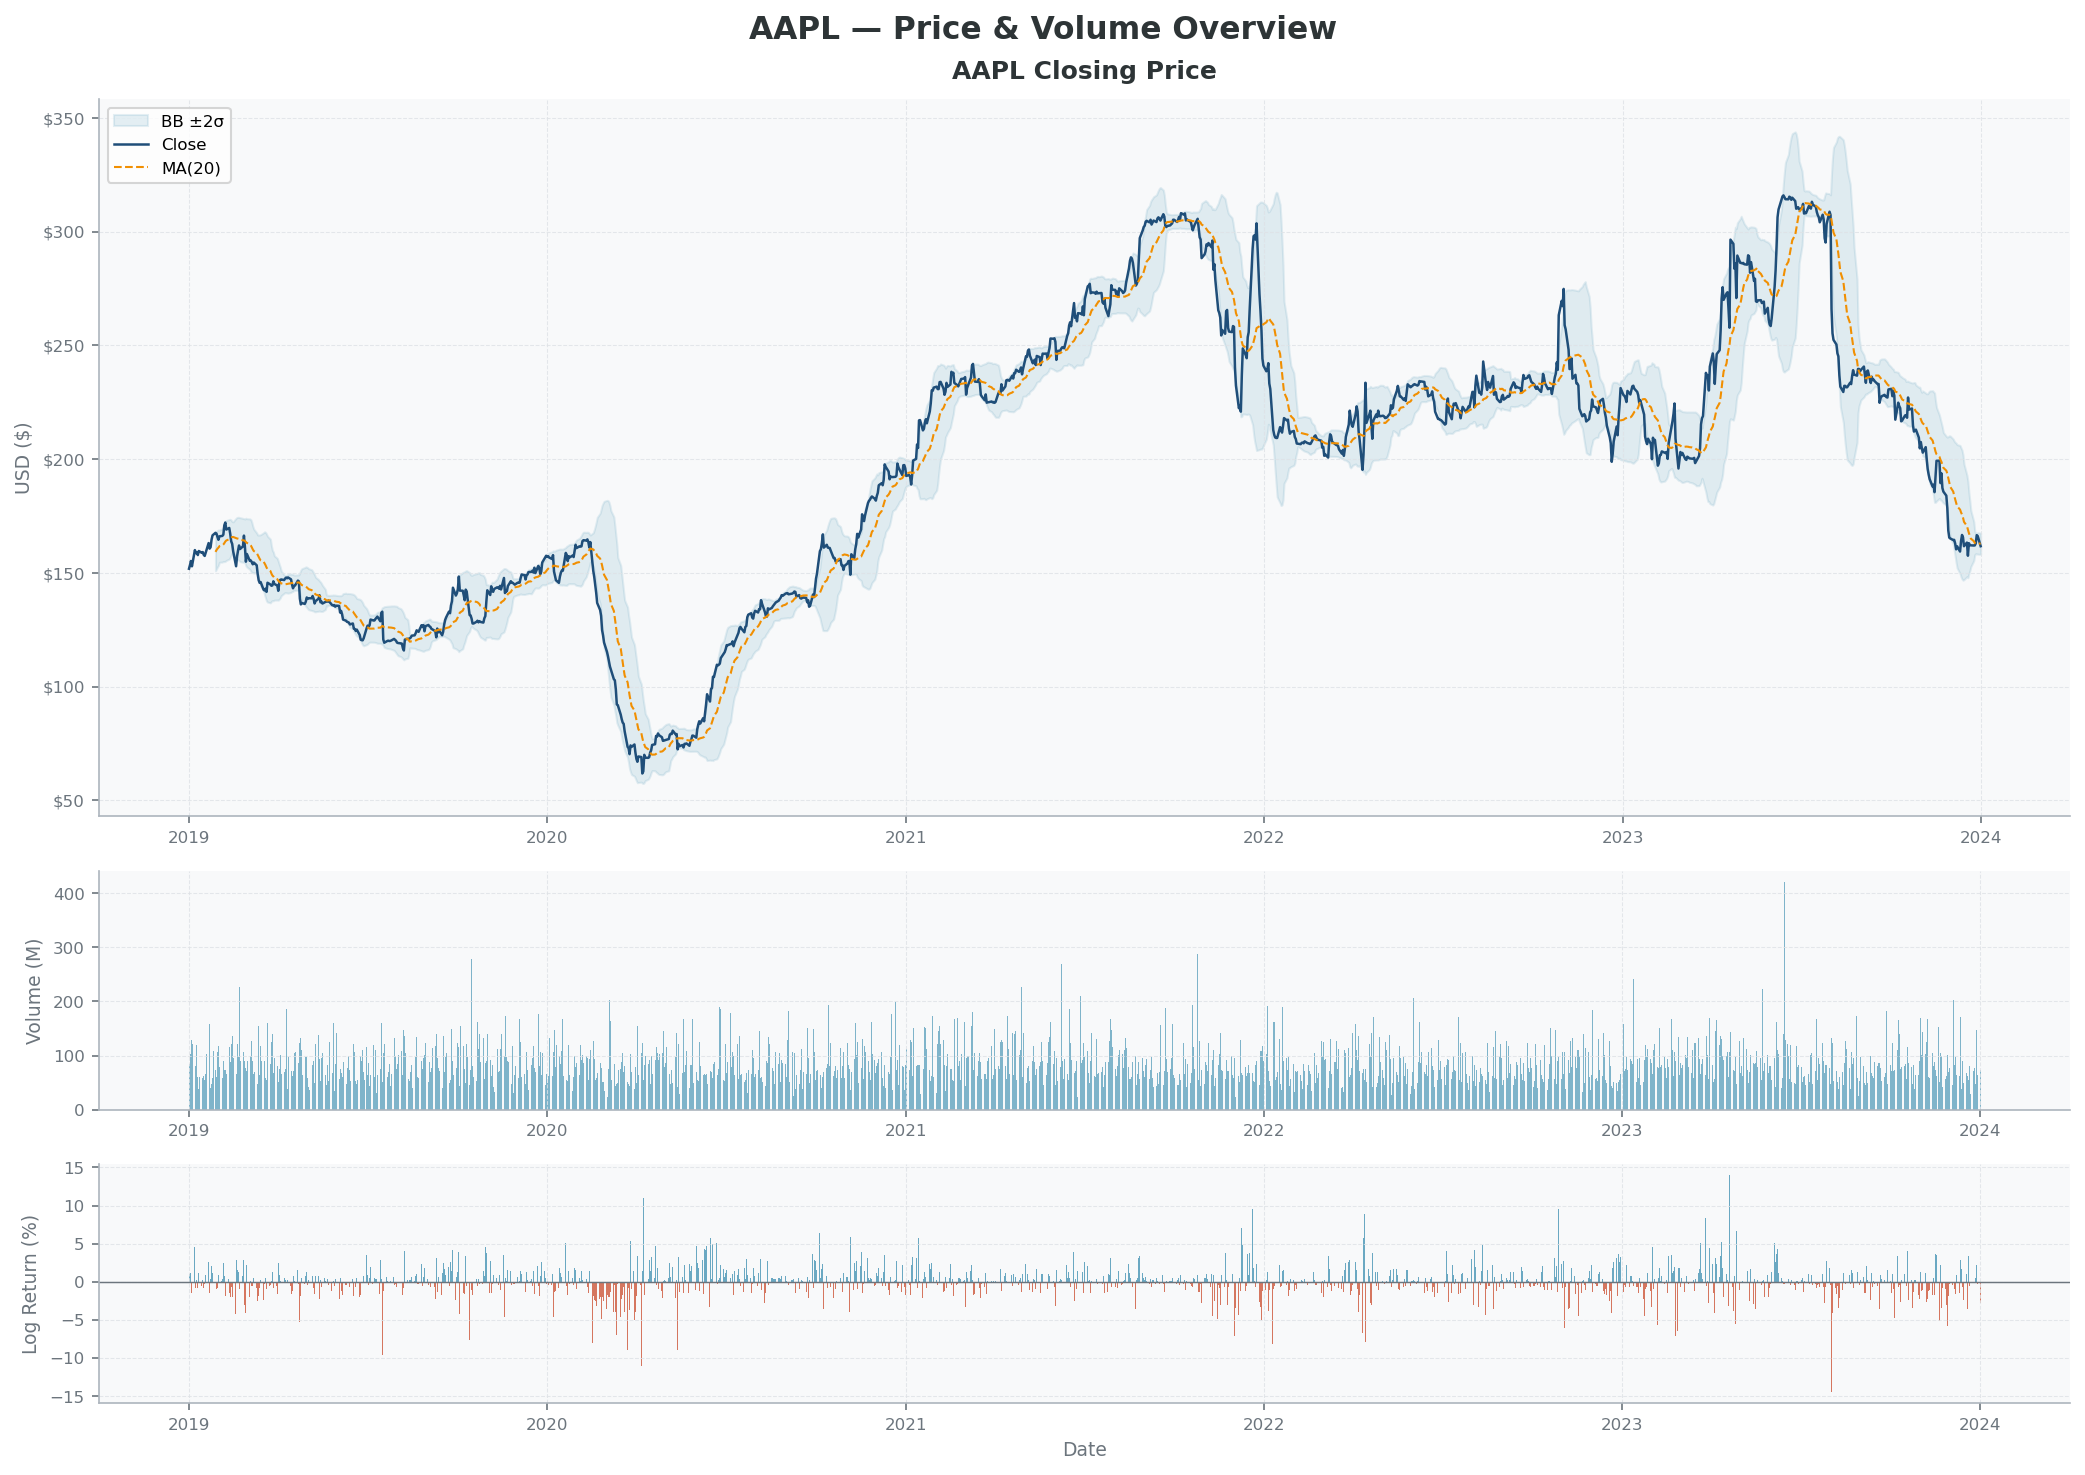

In [6]:
from src.visualization import plot_price_overview
path = plot_price_overview(df, 'AAPL')
from IPython.display import Image
Image(str(path))

## 4. Return Distribution

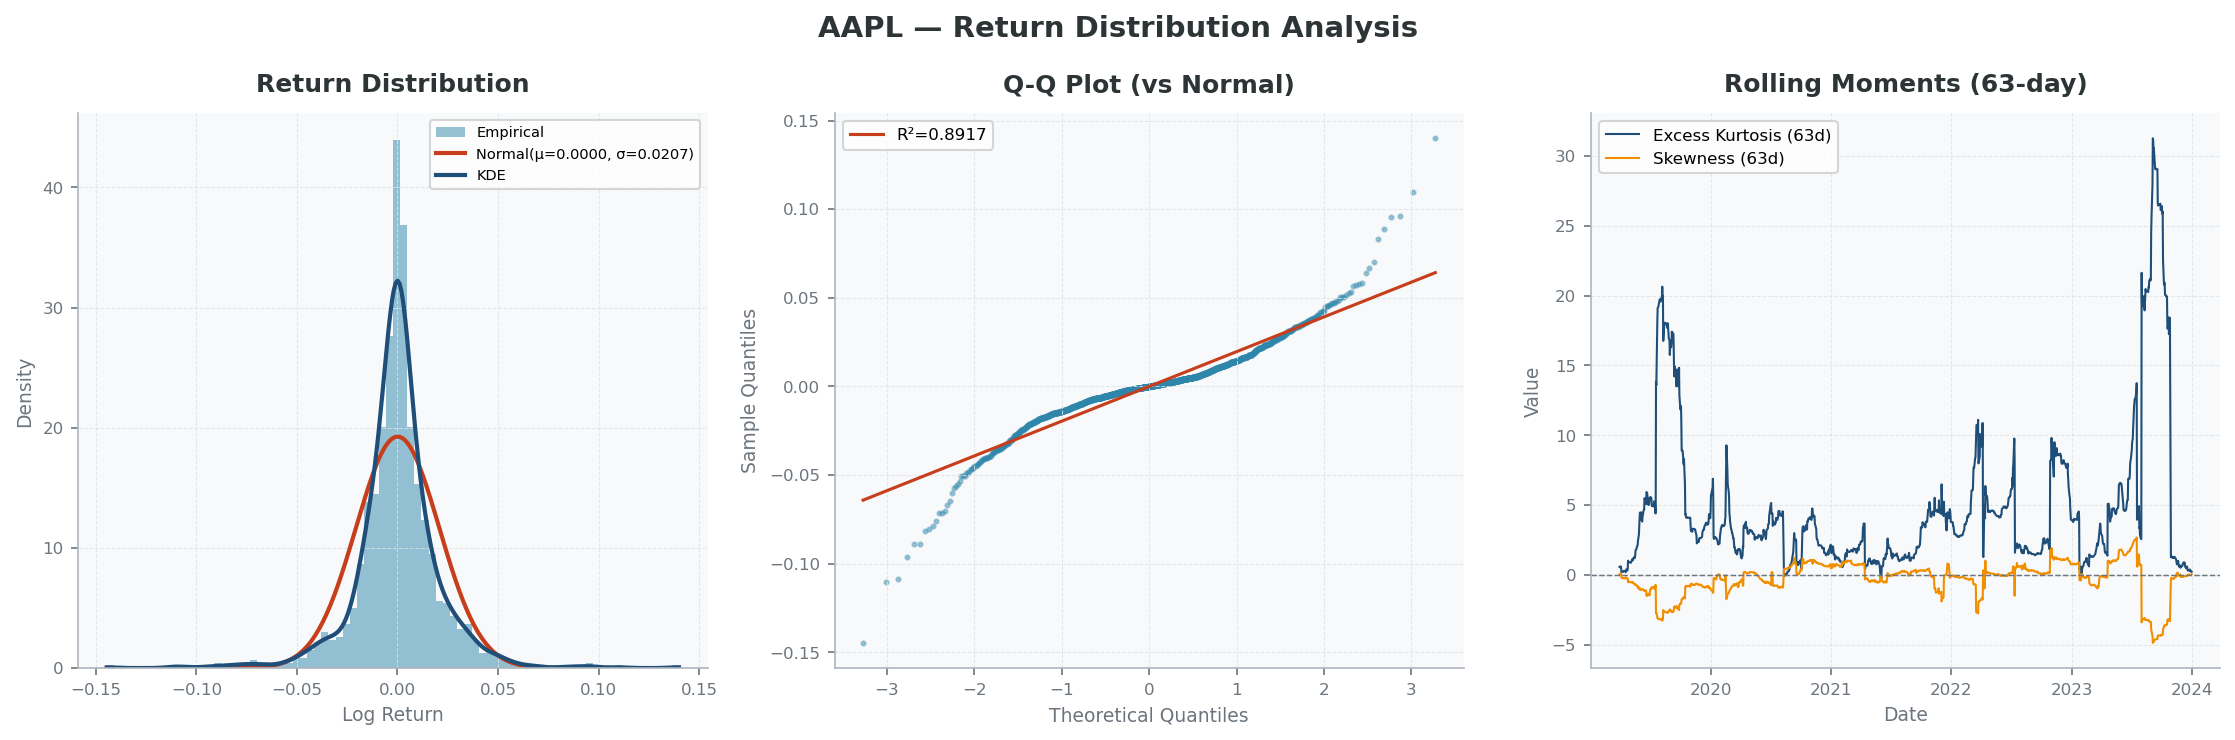

In [7]:
from src.visualization import plot_return_distribution
path = plot_return_distribution(lr, 'AAPL')
Image(str(path))

In [9]:
# Manual Jarque-Bera interpretation
jb_stat, jb_p = stats.jarque_bera(lr.dropna())
print(f'Jarque-Bera statistic : {jb_stat:.2f}')
print(f'p-value               : {jb_p:.6f}')
print(f'Reject normality?     : {"YES (p < 0.05)" if jb_p < 0.05 else "NO"}')
print()
print(f'Skewness              : {lr.skew():.4f}  (negative = left-skewed)')
print(f'Excess Kurtosis       : {lr.kurtosis():.4f}  (>0 = fat tails)')

Jarque-Bera statistic : 3150.26
p-value               : 0.000000
Reject normality?     : YES (p < 0.05)

Skewness              : -0.2468  (negative = left-skewed)
Excess Kurtosis       : 7.6323  (>0 = fat tails)


## 5. Stationarity Tests

In [10]:
from src.statistical_tests import adf_test, kpss_test, stationarity_diagnosis

print('Testing LOG PRICES (expected: non-stationary)')
print('=' * 50)
diag_prices = stationarity_diagnosis(close, label='Log Price')
print(diag_prices['adf'].summary())
print()
print(diag_prices['kpss'].summary())
print('\nVERDICT:', diag_prices['verdict'])

Testing LOG PRICES (expected: non-stationary)
ADF Test Result: ✅ STATIONARY
  Statistic  : -503.5114
  p-value    : 0.0100
  Lags used  : 23
  Critical values: {'1%': '-3.430', '5%': '-2.862', '10%': '-2.567'}
  The series IS stationary — safe to use directly in models.

KPSS Test Result: ❌ NON-STATIONARY
  Statistic  : 8.0036
  p-value    : 0.0100
  Lags used  : 8
  Critical values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
  Reject H0 — series is NOT stationary (KPSS). Evidence of a unit root or structural break.

VERDICT: ⚠️  TREND-STATIONARY — consider de-trending or using ARIMA with d=0.


In [11]:
print('Testing LOG RETURNS (expected: stationary)')
print('=' * 50)
diag_returns = stationarity_diagnosis(lr, label='Log Returns')
print(diag_returns['adf'].summary())
print()
print(diag_returns['kpss'].summary())
print('\nVERDICT:', diag_returns['verdict'])

Testing LOG RETURNS (expected: stationary)
ADF Test Result: ✅ STATIONARY
  Statistic  : -69.8313
  p-value    : 0.0100
  Lags used  : 0
  Critical values: {'1%': '-3.430', '5%': '-2.862', '10%': '-2.567'}
  The series IS stationary — safe to use directly in models.

KPSS Test Result: ✅ STATIONARY
  Statistic  : 0.1720
  p-value    : 0.1000
  Lags used  : 8
  Critical values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
  Cannot reject H0 — series IS stationary (KPSS).

VERDICT: ✅ STATIONARY — both tests agree. Ready for ARMA/GARCH modelling.


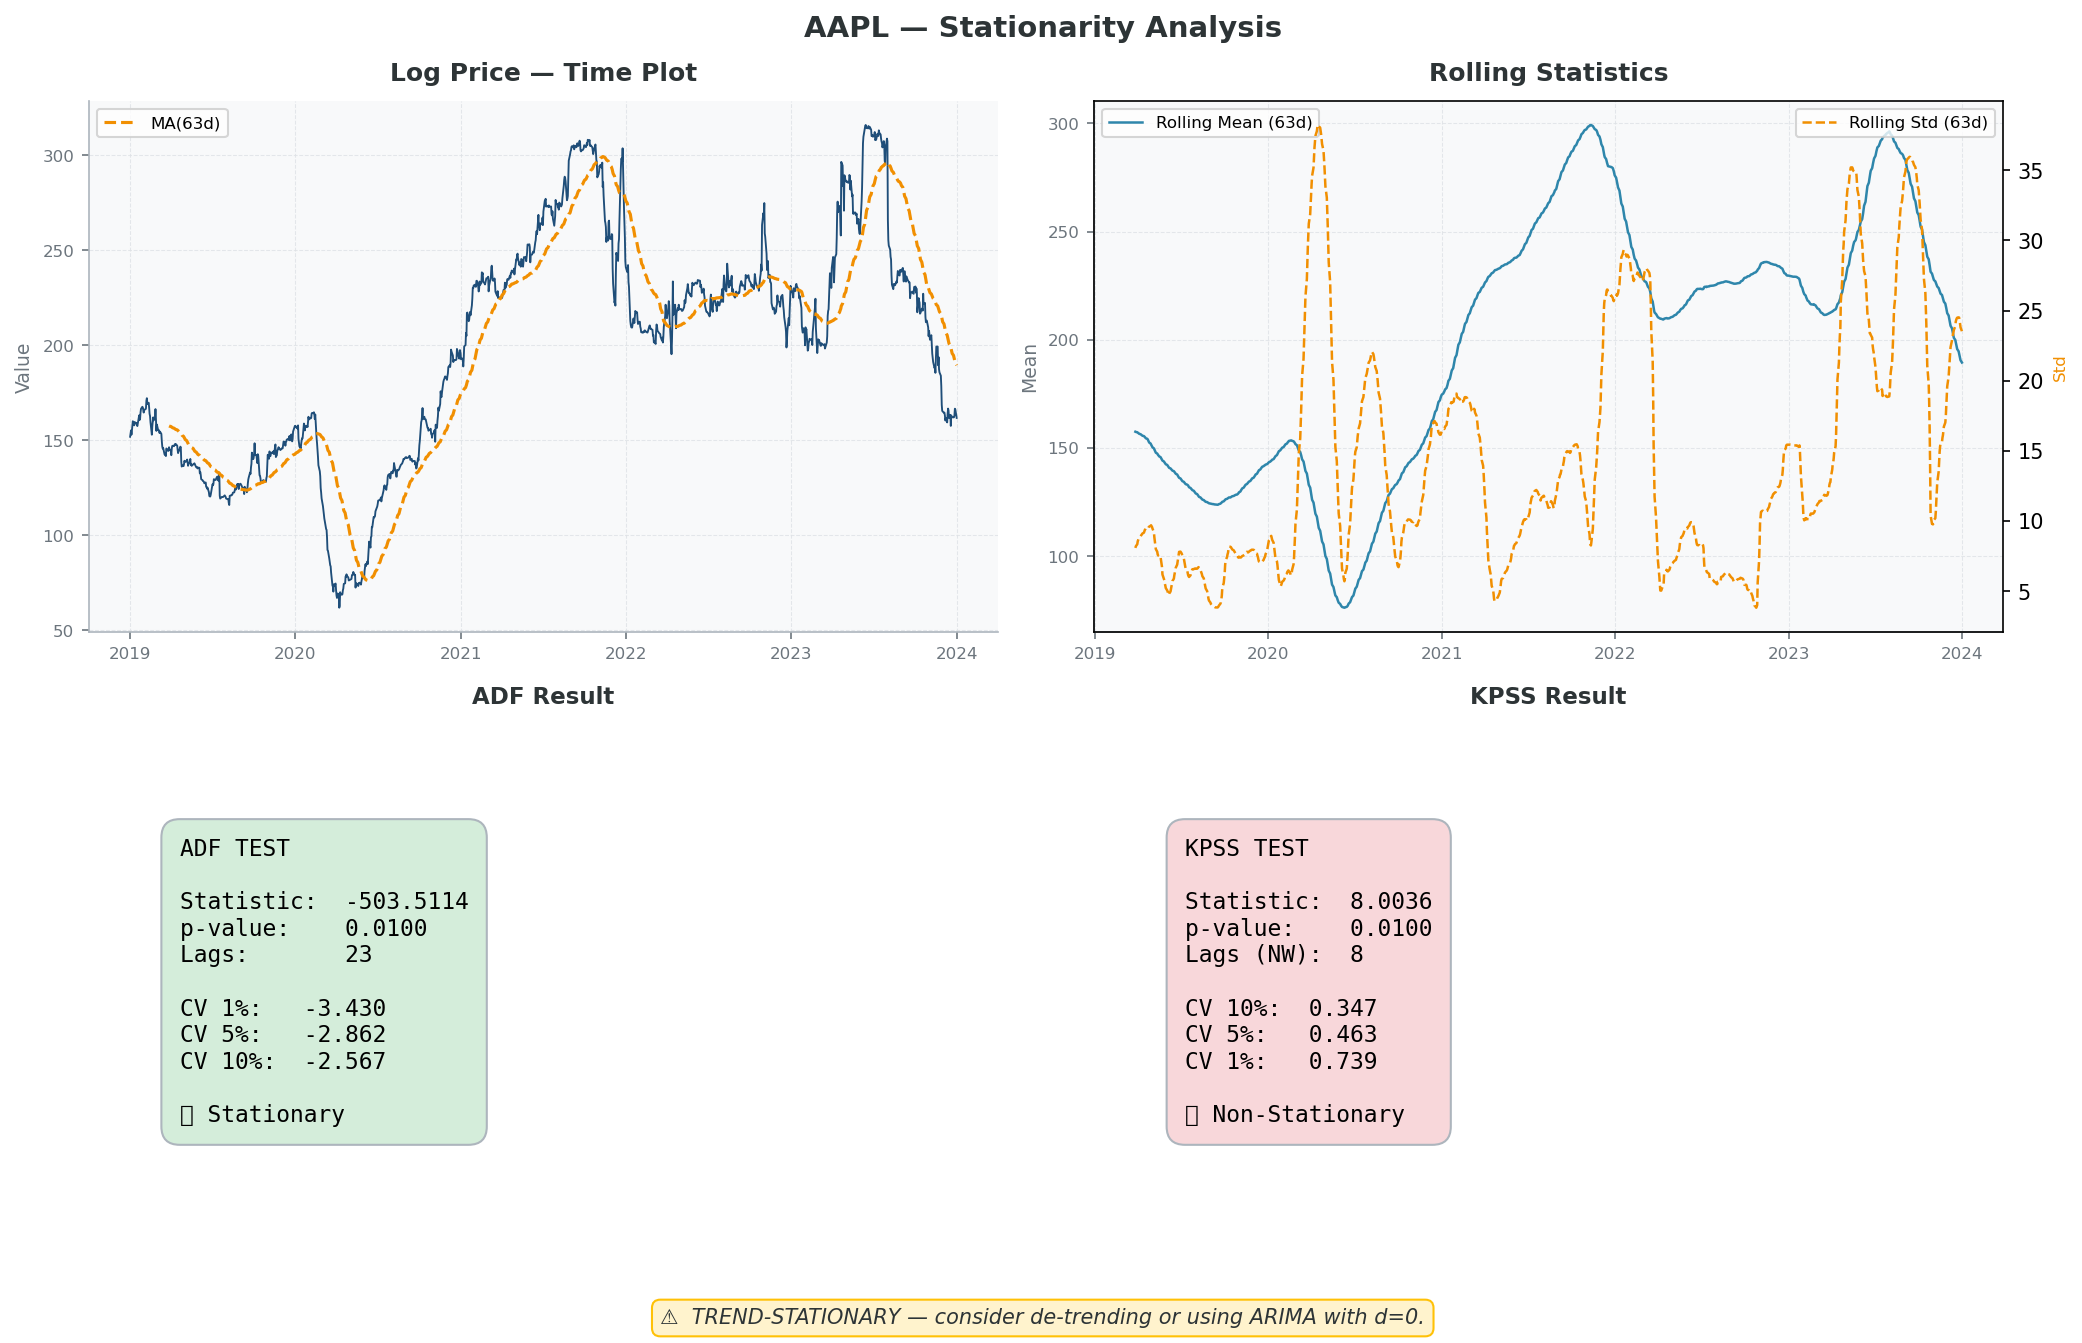

In [12]:
from src.visualization import plot_stationarity
path = plot_stationarity(close, diag_prices, 'AAPL')
Image(str(path))

## 6. ACF / PACF Correlogram

Significant ACF lags  : [1, 2, 4, 6, 8]
Significant PACF lags : [1, 4]
Confidence band (±)   : 0.0543


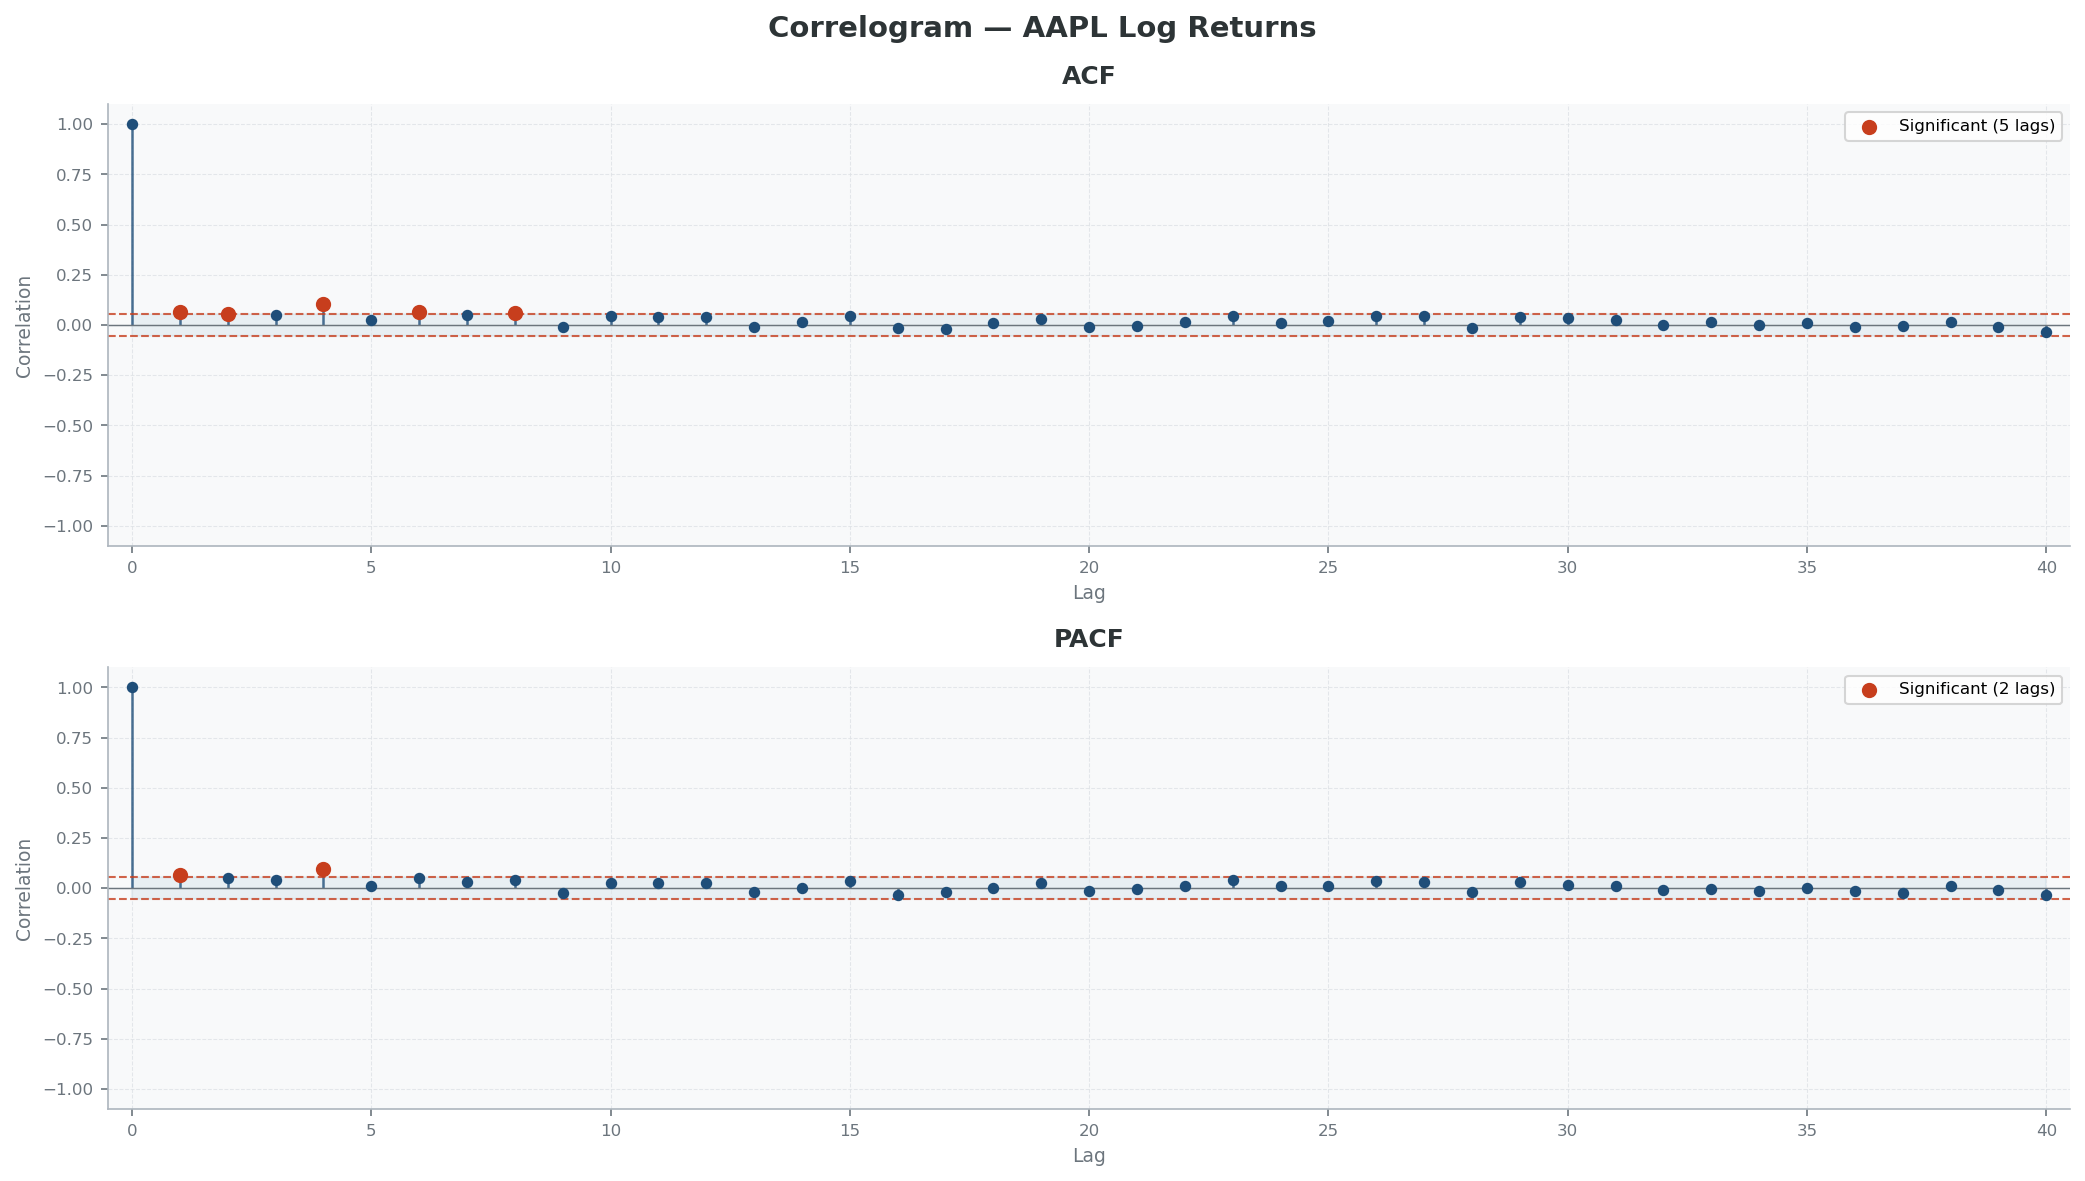

In [13]:
from src.statistical_tests import acf, pacf
from src.visualization import plot_correlogram

acf_res  = acf(lr, n_lags=40)
pacf_res = pacf(lr, n_lags=40)

print(f'Significant ACF lags  : {acf_res.significant_lags}')
print(f'Significant PACF lags : {pacf_res.significant_lags}')
print(f'Confidence band (±)   : {acf_res.conf_band:.4f}')

path = plot_correlogram(acf_res, pacf_res, 'AAPL Log Returns')
Image(str(path))

## 7. Time Series Decomposition

Decomposition (additive, period=252)
  Trend strength   : 0.872
  Seasonal strength: 0.282
  Residual std     : 21.611055



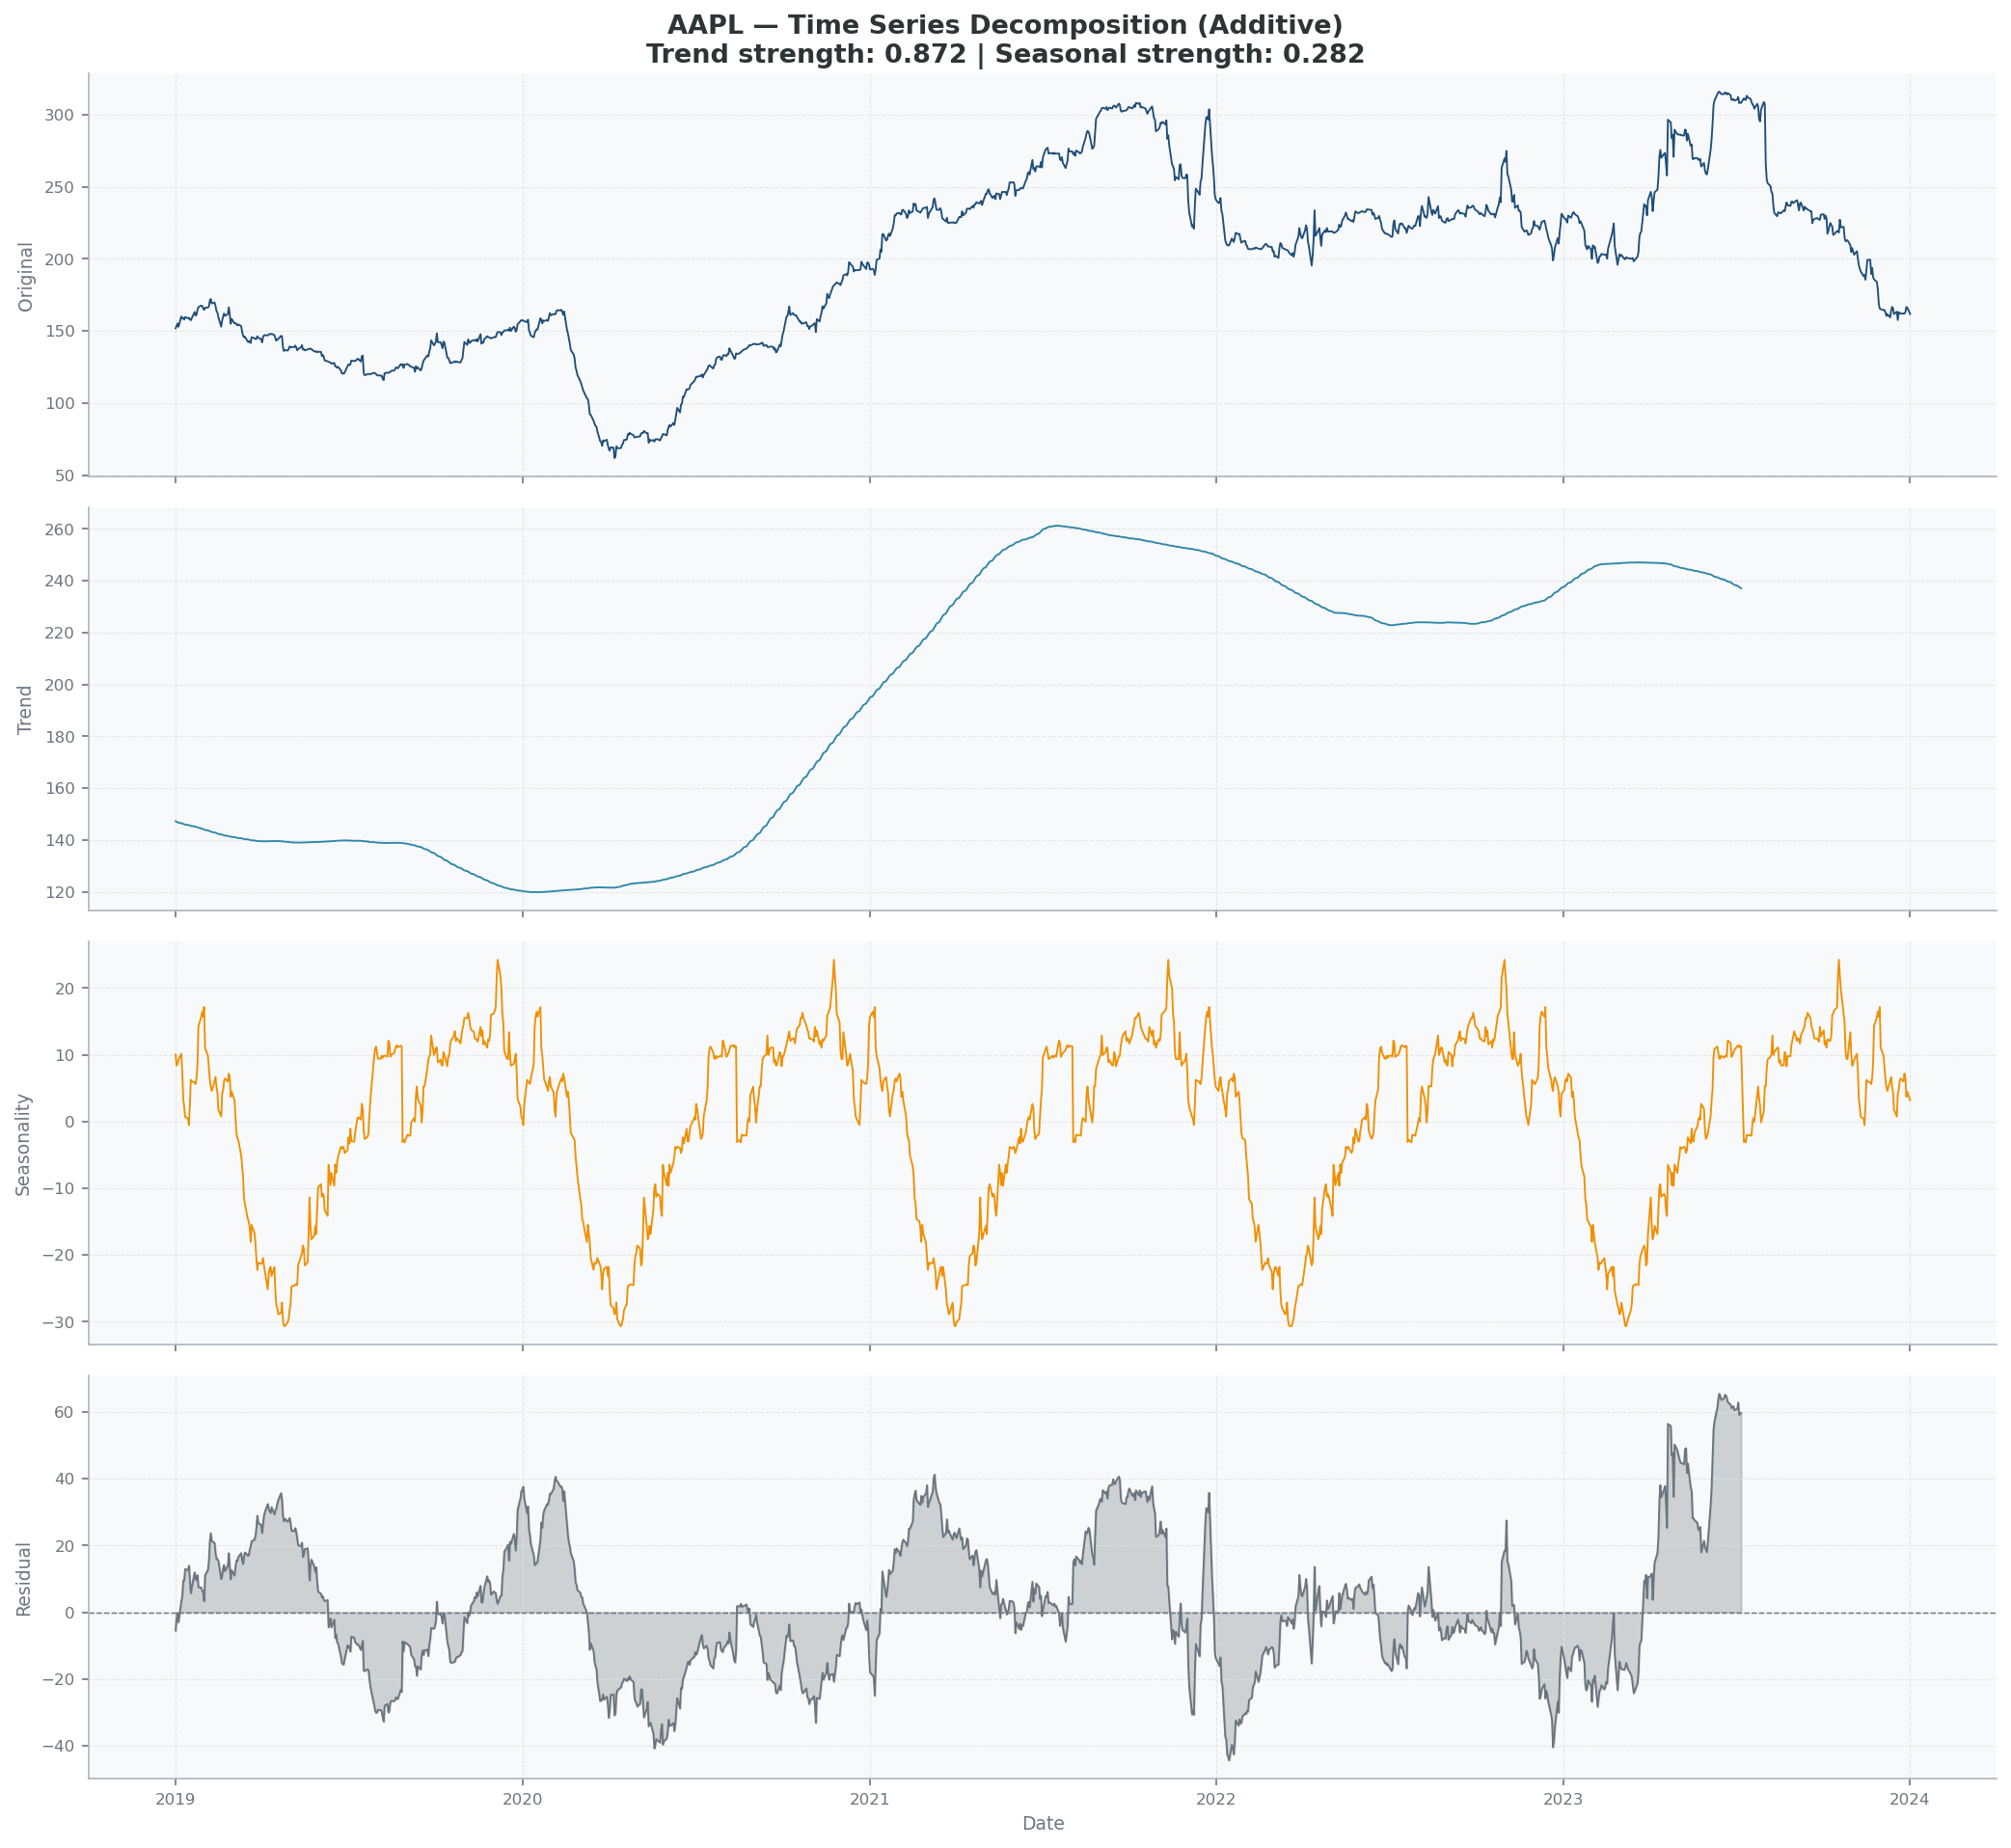

In [14]:
from src.decomposition import classical_decompose, hodrick_prescott
from src.visualization import plot_decomposition

dec = classical_decompose(close, period=252, model='additive')
print(dec.summary())

path = plot_decomposition(dec, 'AAPL')
Image(str(path))

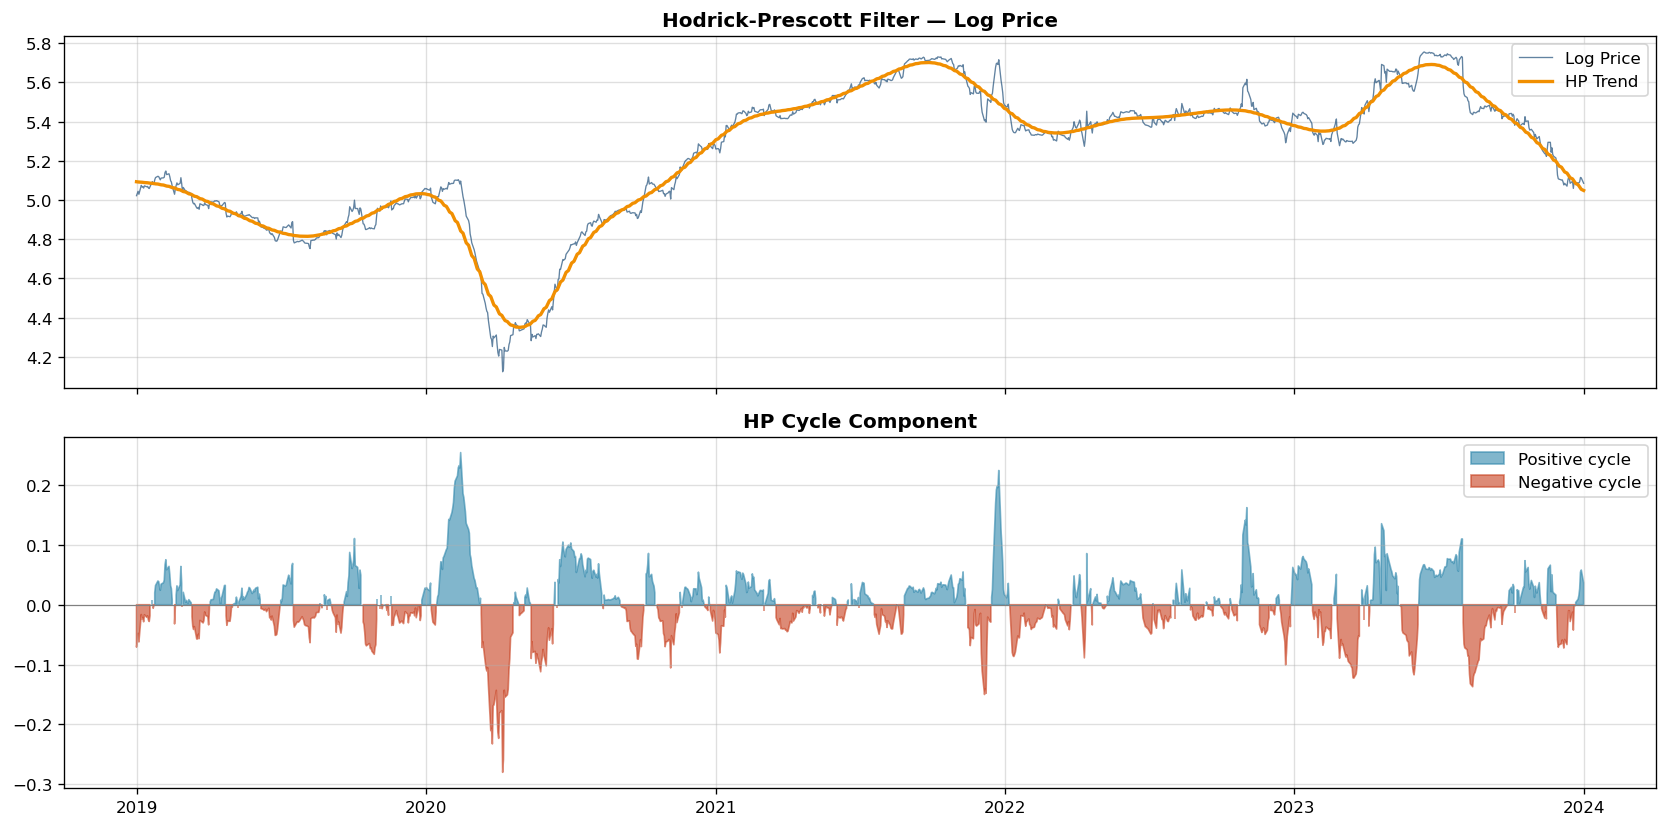

In [15]:
# Hodrick-Prescott filter on log prices
import numpy as np
hp_trend, hp_cycle = hodrick_prescott(np.log(close), lamb=129600)  # daily lambda

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
axes[0].plot(close.index, np.log(close), color='#1f4e79', linewidth=0.8, alpha=0.7, label='Log Price')
axes[0].plot(hp_trend.index, hp_trend, color='#f18f01', linewidth=2, label='HP Trend')
axes[0].set_title('Hodrick-Prescott Filter — Log Price', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.4)

axes[1].fill_between(hp_cycle.index, hp_cycle, 0,
                     where=hp_cycle>0, color='#2e86ab', alpha=0.6, label='Positive cycle')
axes[1].fill_between(hp_cycle.index, hp_cycle, 0,
                     where=hp_cycle<0, color='#c73e1d', alpha=0.6, label='Negative cycle')
axes[1].axhline(0, color='grey', linewidth=0.7)
axes[1].set_title('HP Cycle Component', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

## 8. Volatility Clustering & Risk Metrics

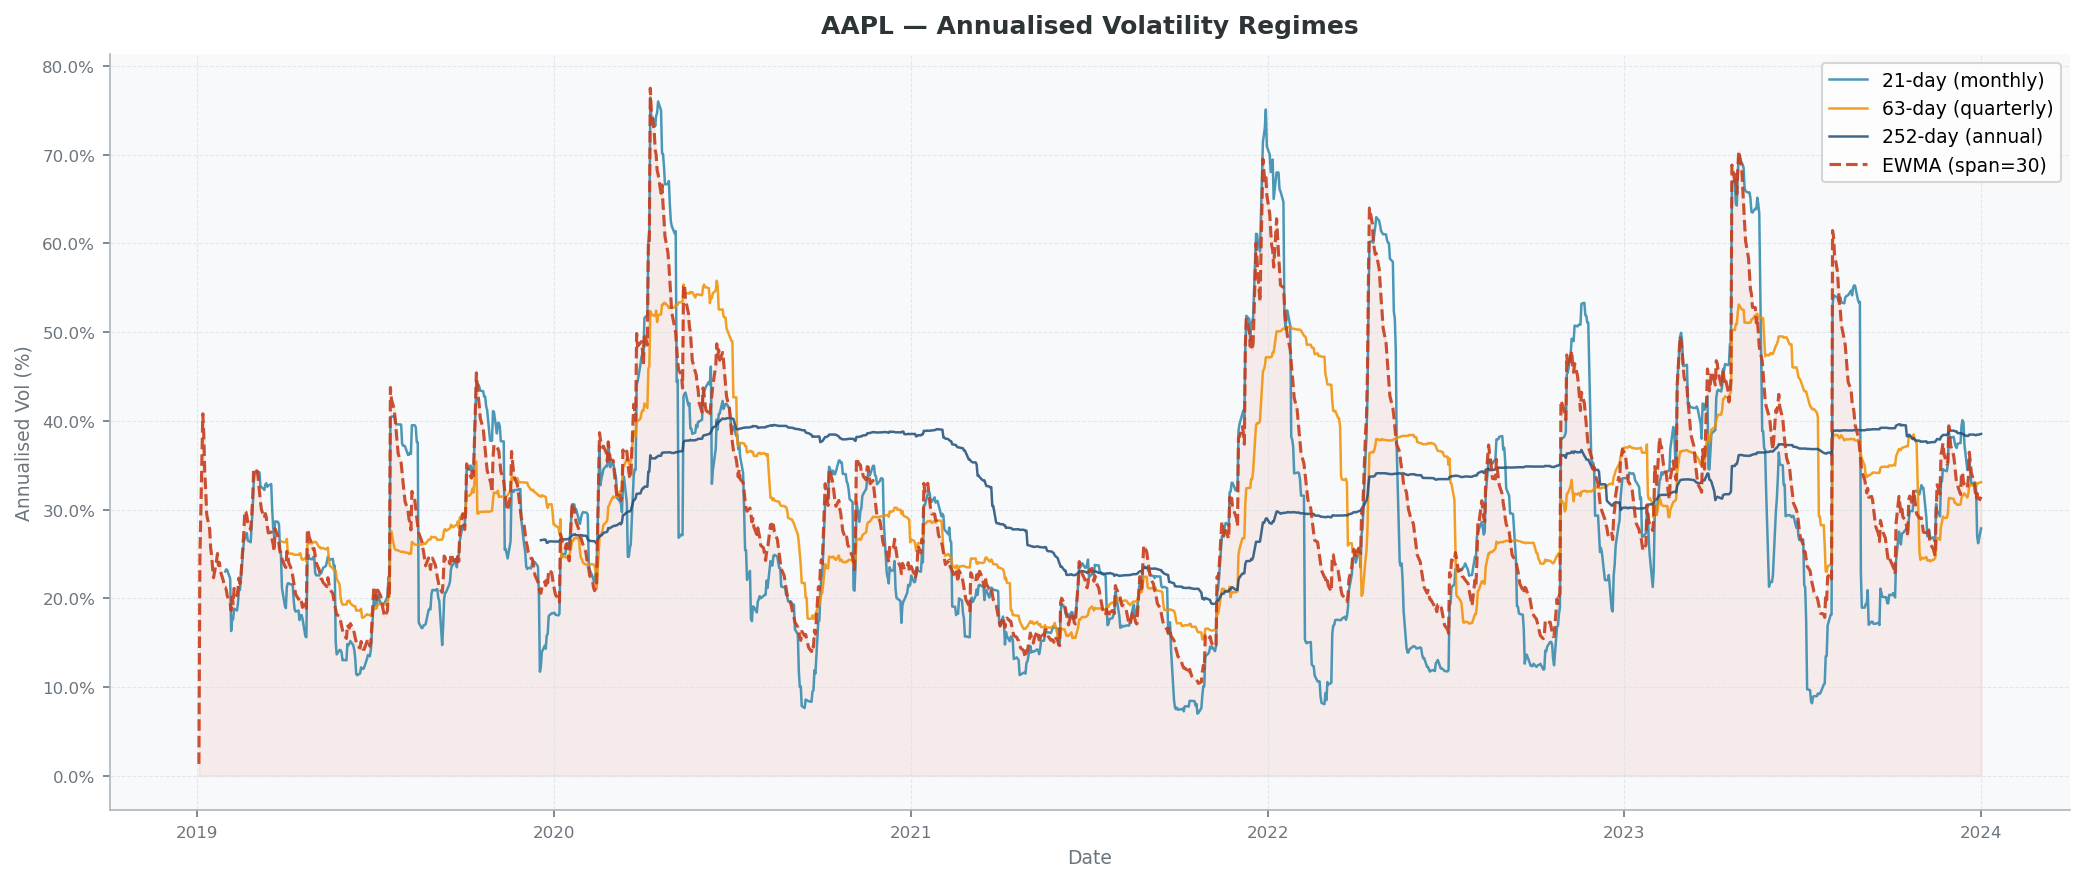

In [16]:
from src.visualization import plot_rolling_volatility, plot_volatility_clustering

path = plot_rolling_volatility(lr, 'AAPL')
Image(str(path))

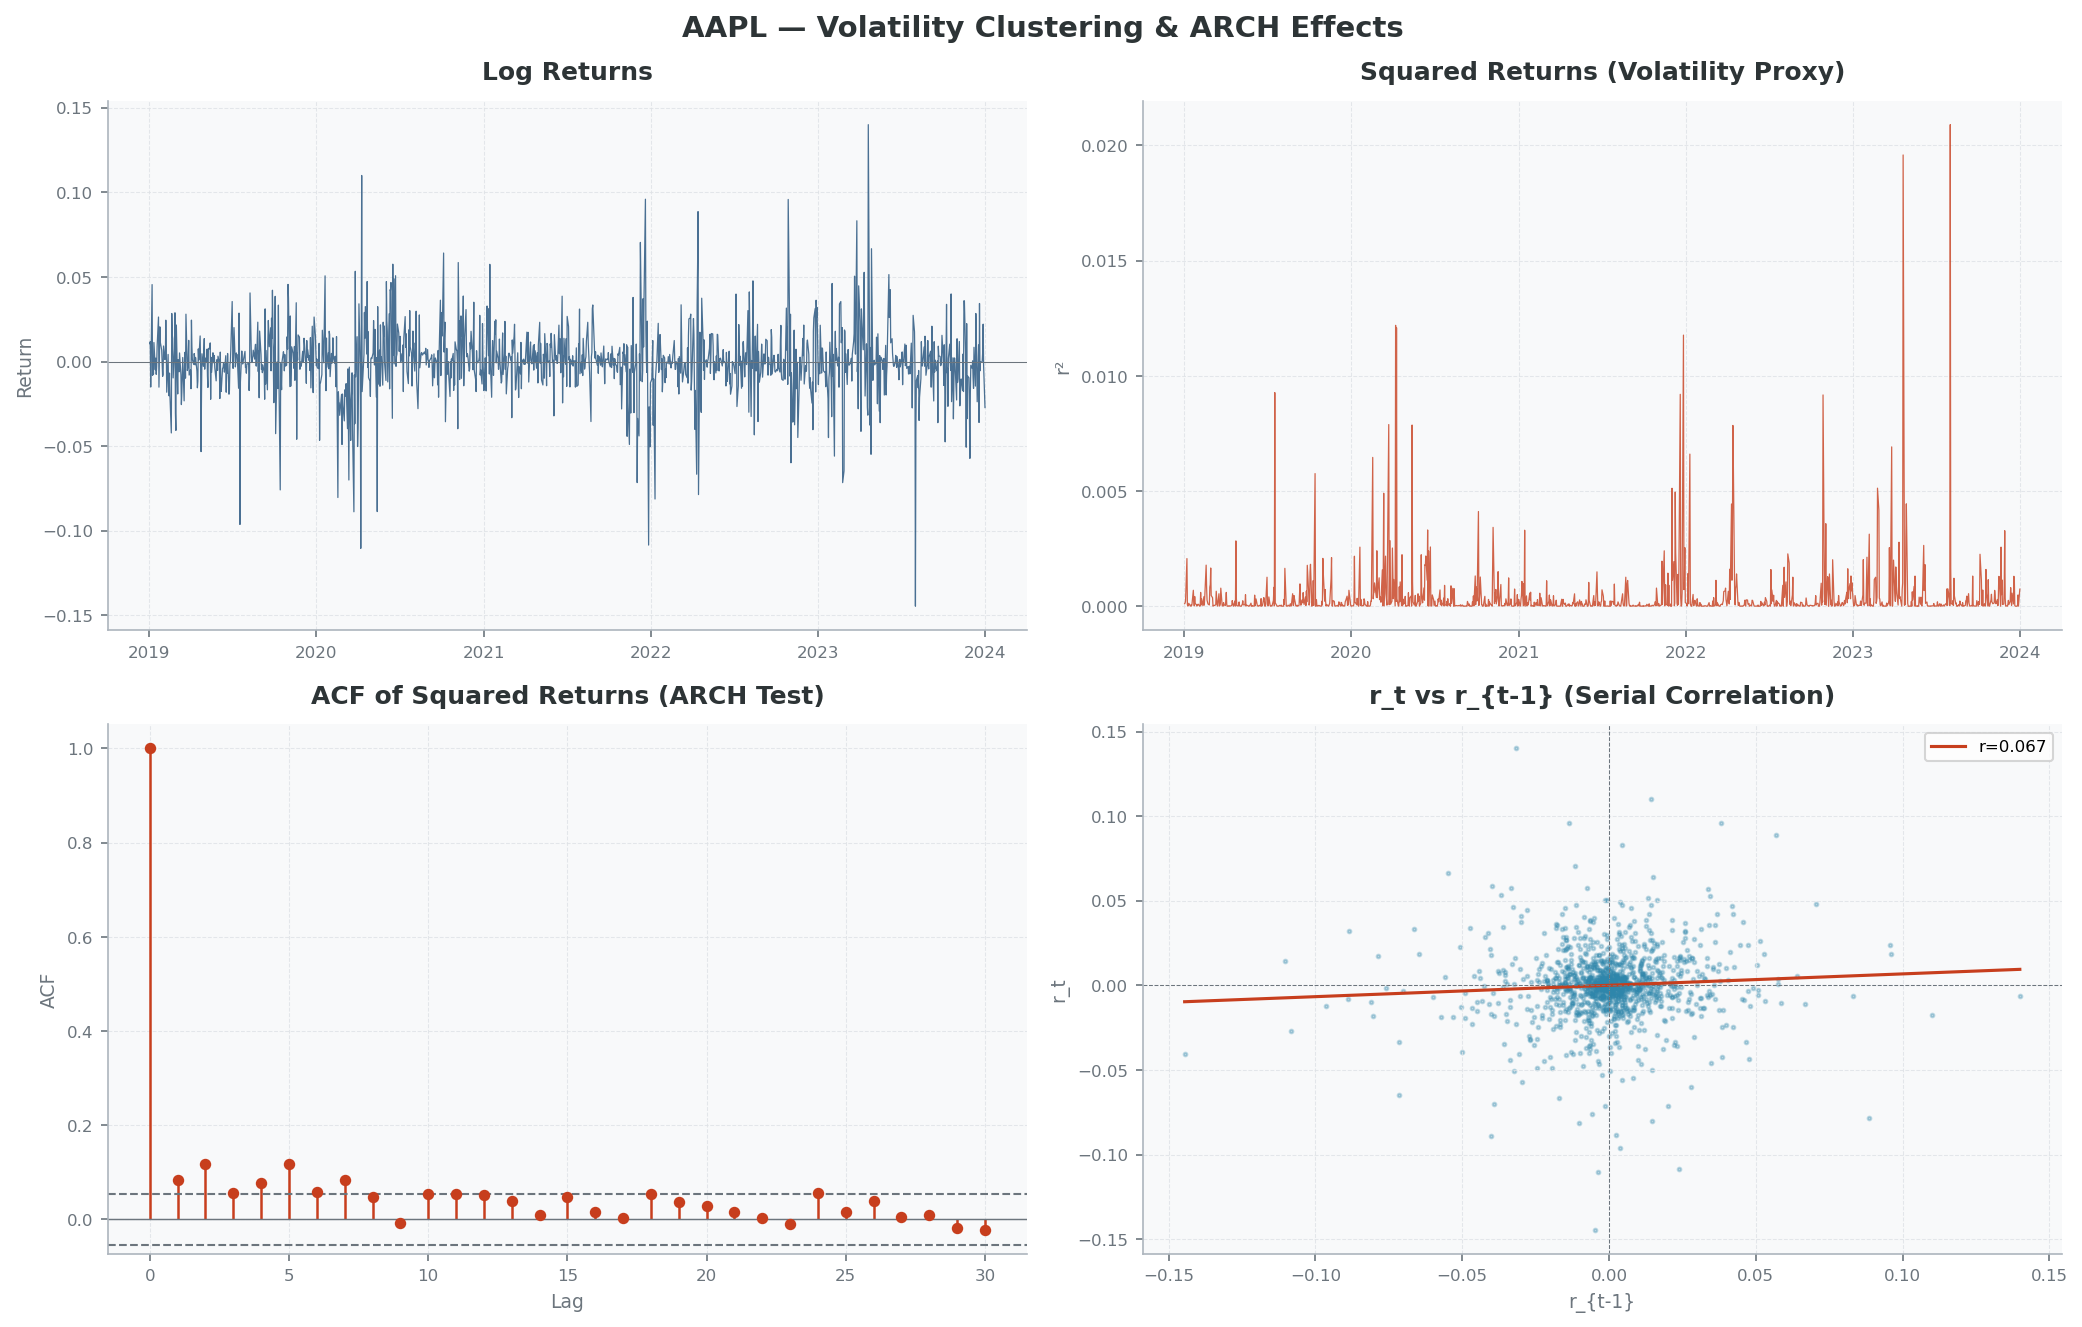

In [17]:
path = plot_volatility_clustering(lr, 'AAPL')
Image(str(path))

## 9. Calendar & Drawdown Analysis

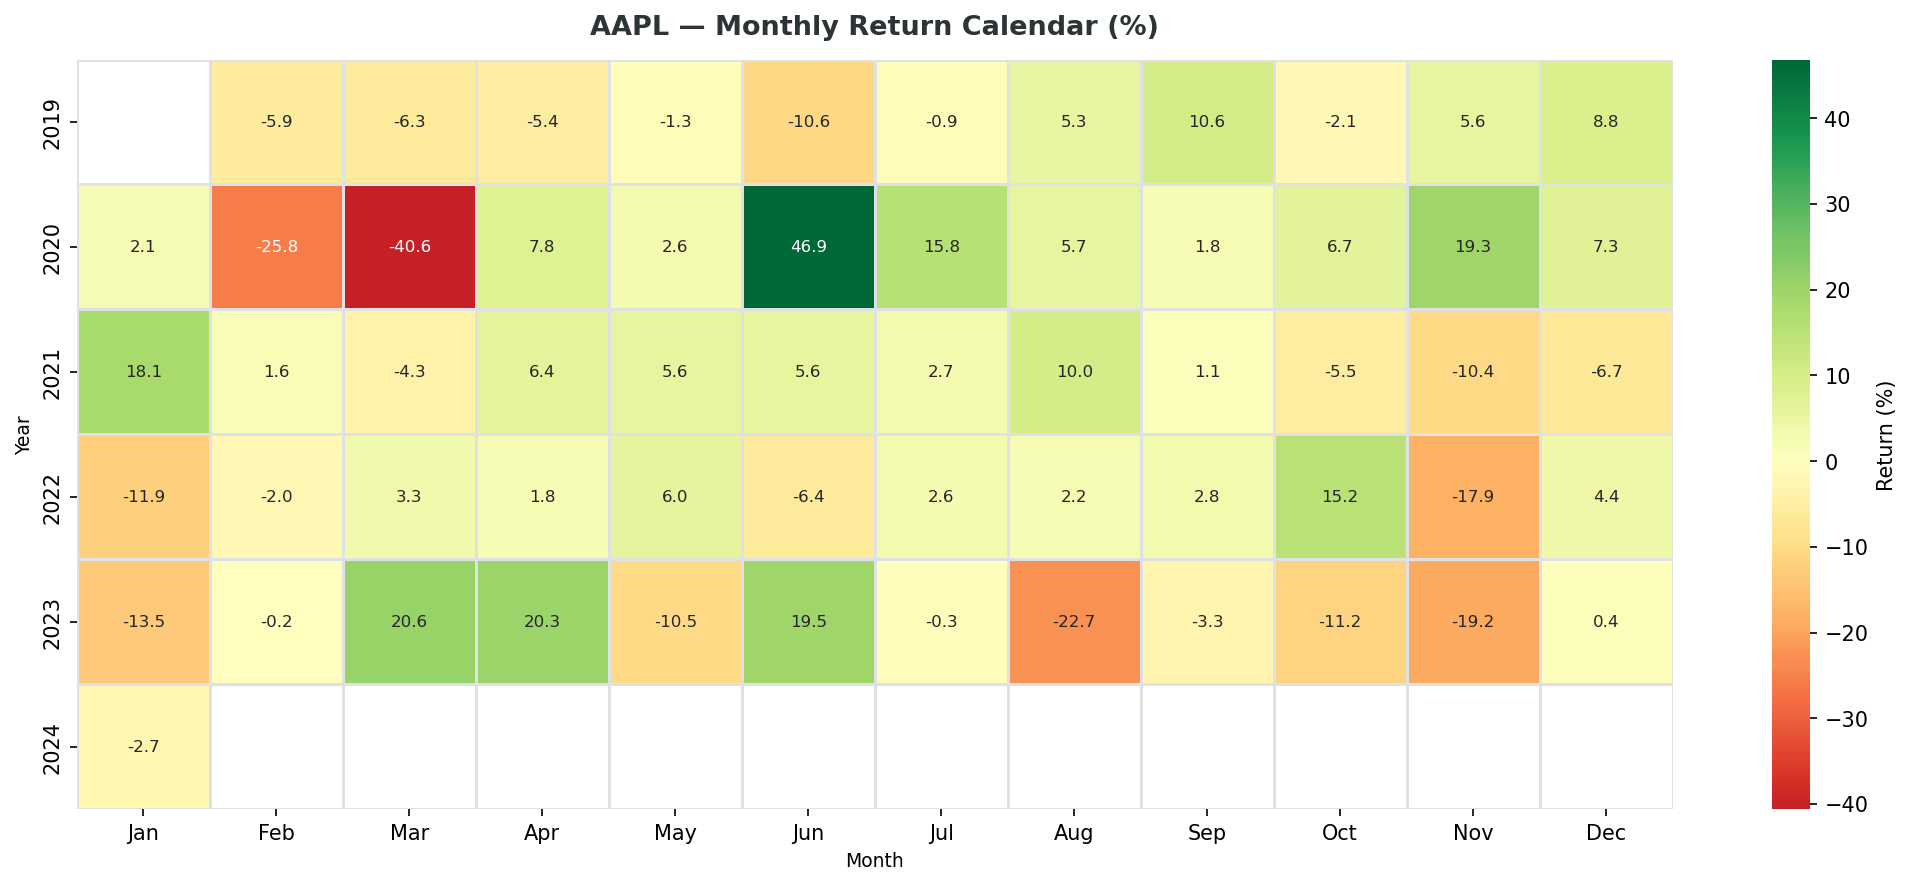

In [18]:
from src.visualization import plot_monthly_returns_heatmap, plot_drawdown

path = plot_monthly_returns_heatmap(close, 'AAPL')
Image(str(path))

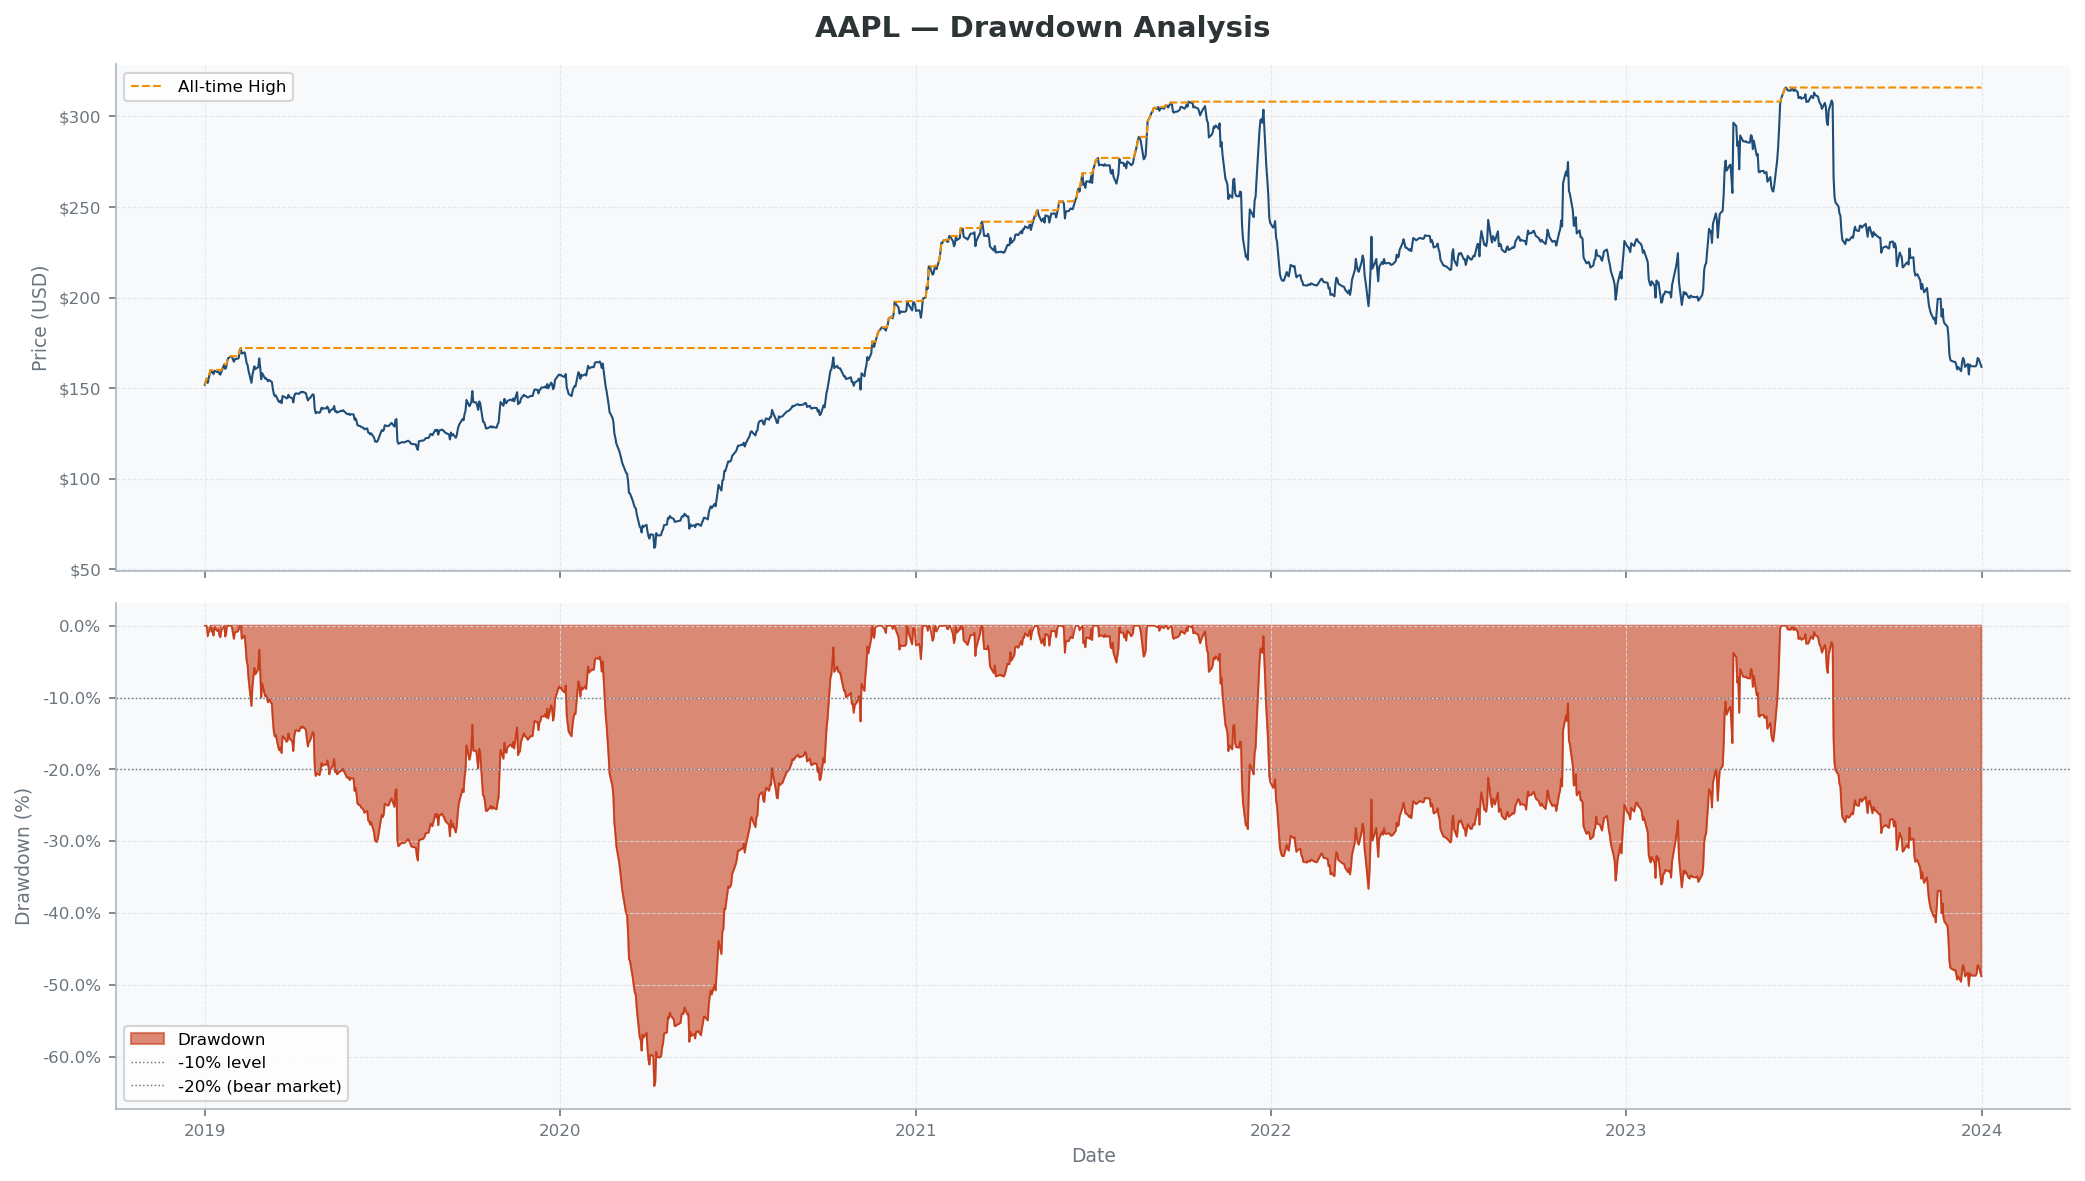

In [19]:
path = plot_drawdown(close, 'AAPL')
Image(str(path))

## 10. Summary & Conclusions

| Finding | Value | Implication |
|---------|-------|-------------|
| Log returns stationarity | ✅ Confirmed (ADF+KPSS) | Use returns, not prices, for modelling |
| Excess kurtosis | 7.63 | Fat tails — use Student-t or EVT, not Normal |
| Skewness | −0.25 | Slight left tail — downside risk asymmetry |
| VaR (5%, daily) | −3.26% | 1-in-20 day loss threshold |
| CVaR (5%, daily) | −5.19% | Average loss on worst 5% days |
| ACF significant lags | 1, 2, 4, 6, 8 | Weak predictability → consider ARMA(4,q) |
| ARCH effects | Confirmed | GARCH model required for vol forecasting |
| Trend strength | 0.87 | Strongly trend-driven series |
| Max drawdown | ~−35% | COVID-19 crash (Feb–Mar 2020) |

### Next Steps
1. **GARCH(1,1) / GJR-GARCH** for volatility forecasting
2. **ARMA-GARCH** joint estimation for returns
3. **Regime-switching (HMM)** to formalise the 3 volatility regimes
4. **Monte Carlo simulation** for portfolio VaR under fat-tail assumptions
